
# Filter design tutorial

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to create basic digital filters
(impulse responses) and their properties.

We look into low-pass, high-pass and band-pass filters based on
windowed-sinc kernels, and frequency sampling method.

<div class="alert alert-danger"><h4>Warning</h4><p>This tutorial requires prototype DSP features, which are
   available in nightly builds.

   Please refer to https://pytorch.org/get-started/locally
   for instructions for installing a nightly build.</p></div>


In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt

2.3.0.dev20240222
2.2.0.dev20240222


In [2]:
def sinc_impulse_response(cutoff: torch.Tensor, window_size: int = 513, high_pass: bool = False):
    """Create windowed-sinc impulse response for given cutoff frequencies.

    .. devices:: CPU CUDA

    .. properties:: Autograd TorchScript

    Args:
        cutoff (Tensor): Cutoff frequencies for low-pass sinc filter.

        window_size (int, optional): Size of the Hamming window to apply. Must be odd.
        (Default: 513)

        high_pass (bool, optional):
            If ``True``, convert the resulting filter to high-pass.
            Otherwise low-pass filter is returned. Default: ``False``.

    Returns:
        Tensor: A series of impulse responses. Shape: `(..., window_size)`.
    """
    if window_size % 2 == 0:
        raise ValueError(f"`window_size` must be odd. Given: {window_size}")

    half = window_size // 2
    device, dtype = cutoff.device, cutoff.dtype
    idx = torch.linspace(-half, half, window_size, device=device, dtype=dtype)

    filt = torch.special.sinc(cutoff.unsqueeze(-1) * idx.unsqueeze(0))
    filt = filt * torch.hamming_window(window_size, device=device, dtype=dtype, periodic=False).unsqueeze(0)
    filt = filt / filt.sum(dim=-1, keepdim=True).abs()

    # High pass IR is obtained by subtracting low_pass IR from delta function.
    # https://courses.engr.illinois.edu/ece401/fa2020/slides/lec10.pdf
    if high_pass:
        filt = -filt
        filt[..., half] = 1.0 + filt[..., half]
    return filt


def frequency_impulse_response(magnitudes):
    """Create filter from desired frequency response

    Args:
        magnitudes: The desired frequency responses. Shape: `(..., num_fft_bins)`

    Returns:
        Tensor: Impulse response. Shape `(..., 2 * (num_fft_bins - 1))`
    """
    if magnitudes.min() < 0.0:
        # Negative magnitude does not make sense but allowing so that autograd works
        # around 0.
        # Should we raise error?
        warnings.warn("The input frequency response should not contain negative values.")
    ir = torch.fft.fftshift(torch.fft.irfft(magnitudes), dim=-1)
    device, dtype = magnitudes.device, magnitudes.dtype
    window = torch.hann_window(ir.size(-1), periodic=False, device=device, dtype=dtype).expand_as(ir)
    return ir * window

## Windowed-Sinc Filter


[Sinc filter](https://en.wikipedia.org/wiki/Sinc_filter) is an
idealized filter which removes frequencies above the cutoff
frequency without affecting the lower frequencies.

Sinc filter has infinite filter width in analytical solution.
In numerical computation, sinc filter cannot be expressed exactly,
so an approximation is required.

Windowed-sinc finite impulse response is an approximation of sinc
filter. It is obtained by first evaluating sinc function for given
cutoff frequencies, then truncating the filter skirt, and
applying a window, such as Hamming window, to reduce the
artifacts introduced from the truncation.

:py:func:`~torchaudio.prototype.functional.sinc_impulse_response`
generates windowed-sinc impulse response for given cutoff
frequencies.




### Low-pass filter



#### Impulse Response

Creating sinc IR is as easy as passing cutoff frequency values to
:py:func:`~torchaudio.prototype.functional.sinc_impulse_response`.




In [3]:
cutoff = torch.linspace(0.0, 1.0, 9)
irs = sinc_impulse_response(cutoff, window_size=513)

print("Cutoff shape:", cutoff.shape)
print("Impulse response shape:", irs.shape)

Cutoff shape: torch.Size([9])
Impulse response shape: torch.Size([9, 513])


Let's visualize the resulting impulse responses.




In [4]:
def plot_sinc_ir(irs, cutoff):
    num_filts, window_size = irs.shape
    half = window_size // 2

    fig, axes = plt.subplots(num_filts, 1, sharex=True, figsize=(9.6, 8))
    t = torch.linspace(-half, half - 1, window_size)
    for ax, ir, coff, color in zip(axes, irs, cutoff, plt.cm.tab10.colors):
        ax.plot(t, ir, linewidth=1.2, color=color, zorder=4, label=f"Cutoff: {coff}")
        ax.legend(loc=(1.05, 0.2), handletextpad=0, handlelength=0)
        ax.grid(True)
    fig.suptitle(
        "Impulse response of sinc low-pass filter for different cut-off frequencies\n"
        "(Frequencies are relative to Nyquist frequency)"
    )
    axes[-1].set_xticks([i * half // 4 for i in range(-4, 5)])
    fig.tight_layout()

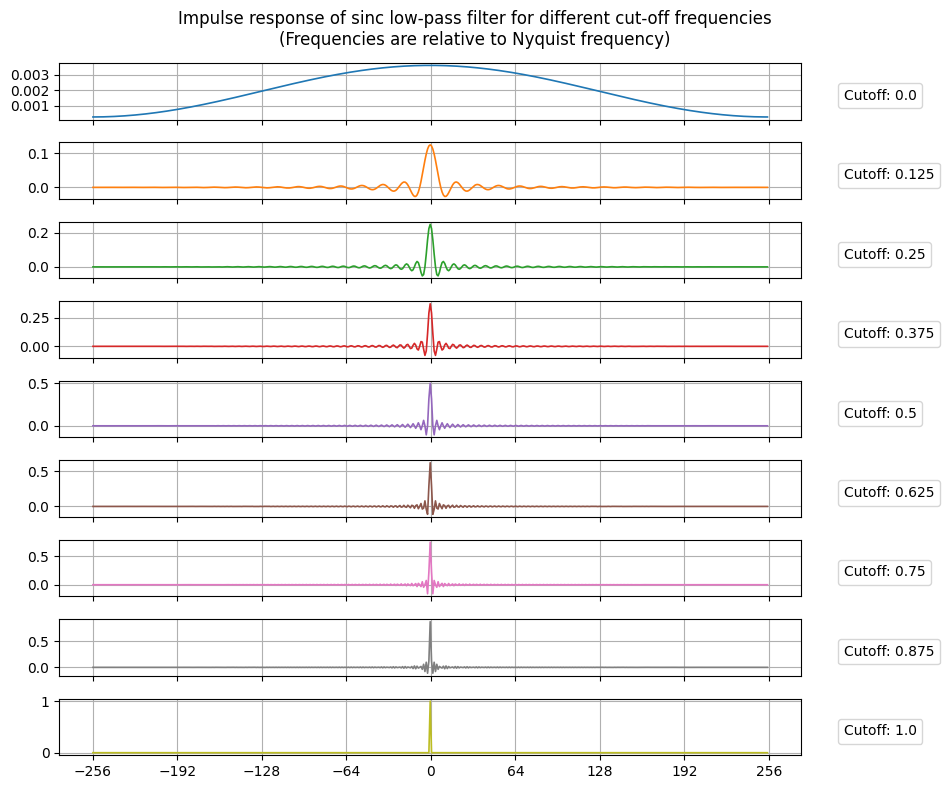

In [5]:
plot_sinc_ir(irs, cutoff)

#### Frequency Response

Next, let's look at the frequency responses.
Simpy applying Fourier transform to the impulse responses will give
the frequency responses.




In [6]:
frs = torch.fft.rfft(irs, n=2048, dim=1).abs()

Let's visualize the resulting frequency responses.




In [7]:
def plot_sinc_fr(frs, cutoff, band=False):
    num_filts, num_fft = frs.shape
    num_ticks = num_filts + 1 if band else num_filts

    fig, axes = plt.subplots(num_filts, 1, sharex=True, sharey=True, figsize=(9.6, 8))
    for ax, fr, coff, color in zip(axes, frs, cutoff, plt.cm.tab10.colors):
        ax.grid(True)
        ax.semilogy(fr, color=color, zorder=4, label=f"Cutoff: {coff}")
        ax.legend(loc=(1.05, 0.2), handletextpad=0, handlelength=0).set_zorder(3)
    axes[-1].set(
        ylim=[None, 100],
        yticks=[1e-9, 1e-6, 1e-3, 1],
        xticks=torch.linspace(0, num_fft, num_ticks),
        xticklabels=[f"{i/(num_ticks - 1)}" for i in range(num_ticks)],
        xlabel="Frequency",
    )
    fig.suptitle(
        "Frequency response of sinc low-pass filter for different cut-off frequencies\n"
        "(Frequencies are relative to Nyquist frequency)"
    )
    fig.tight_layout()

In [8]:
plot_sinc_fr(frs, cutoff)

### High-pass filter

High-pass filter can be obtained by subtracting low-pass
impulse response from the Dirac delta function.

Passing ``high_pass=True`` to
:py:func:`~torchaudio.prototype.functional.sinc_impulse_response`
will change the returned filter kernel to high pass filter.




In [ ]:
irs = sinc_impulse_response(cutoff, window_size=513, high_pass=True)
frs = torch.fft.rfft(irs, n=2048, dim=1).abs()

#### Impulse Response




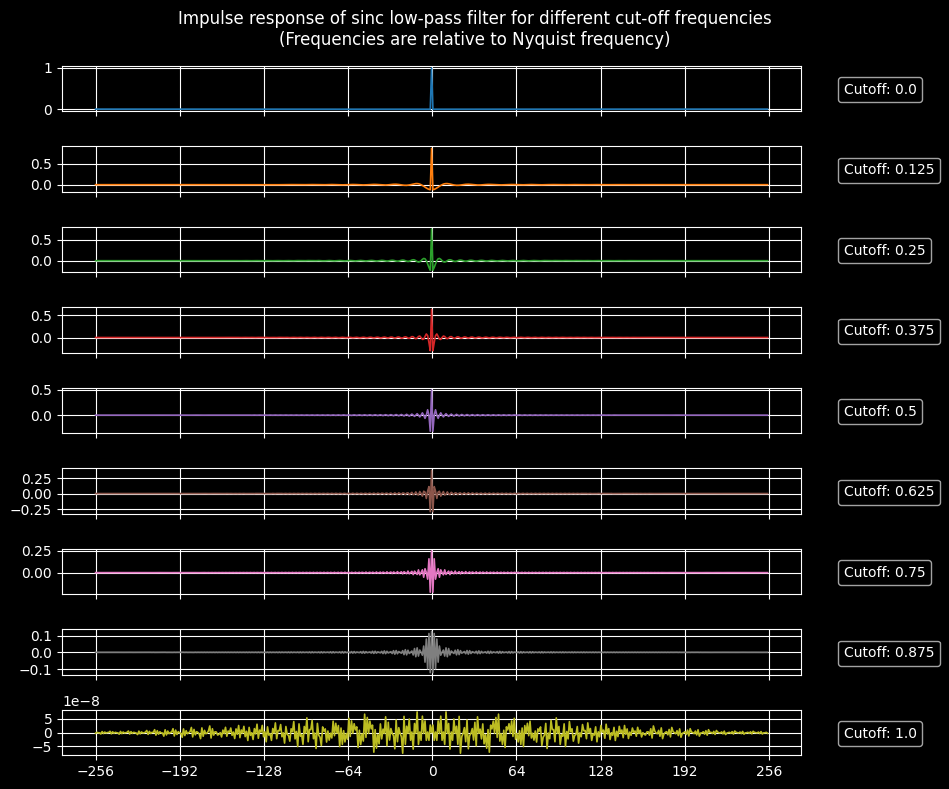

In [ ]:
plot_sinc_ir(irs, cutoff)

#### Frequency Response




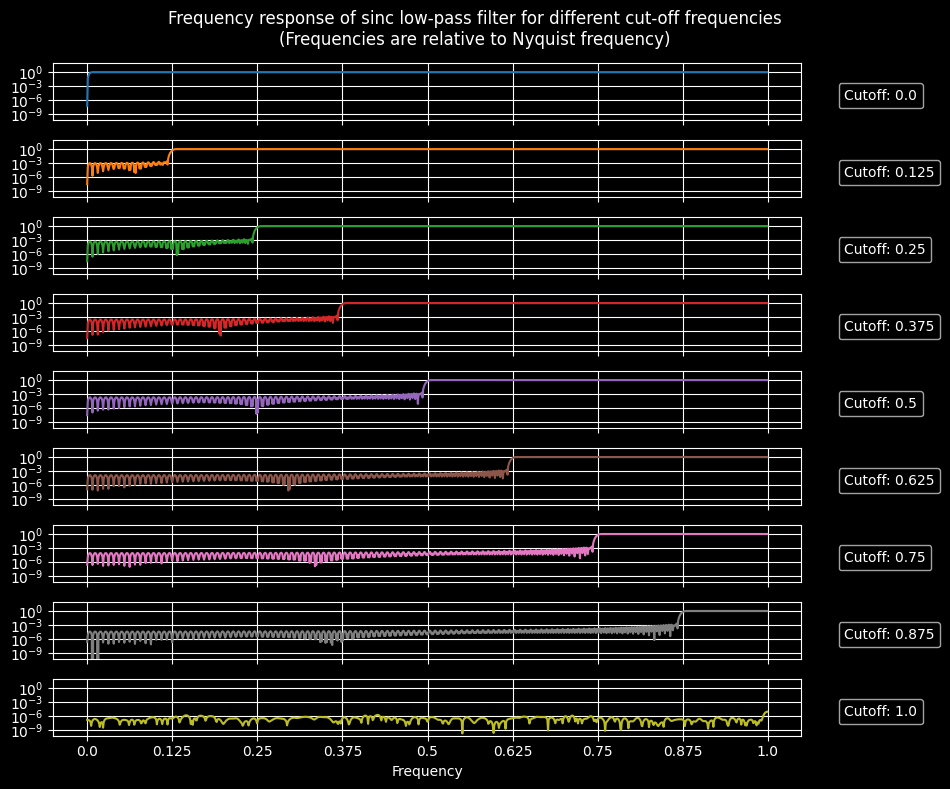

In [ ]:
plot_sinc_fr(frs, cutoff)

### Band-pass filter

Band-pass filter can be obtained by subtracting low-pass filter for
upper band from that of lower band.



In [ ]:
cutoff = torch.linspace(0.0, 1, 11)
c_low = cutoff[:-1]
c_high = cutoff[1:]

irs = sinc_impulse_response(c_low, window_size=513) - sinc_impulse_response(c_high, window_size=513)
frs = torch.fft.rfft(irs, n=2048, dim=1).abs()

#### Impulse Response




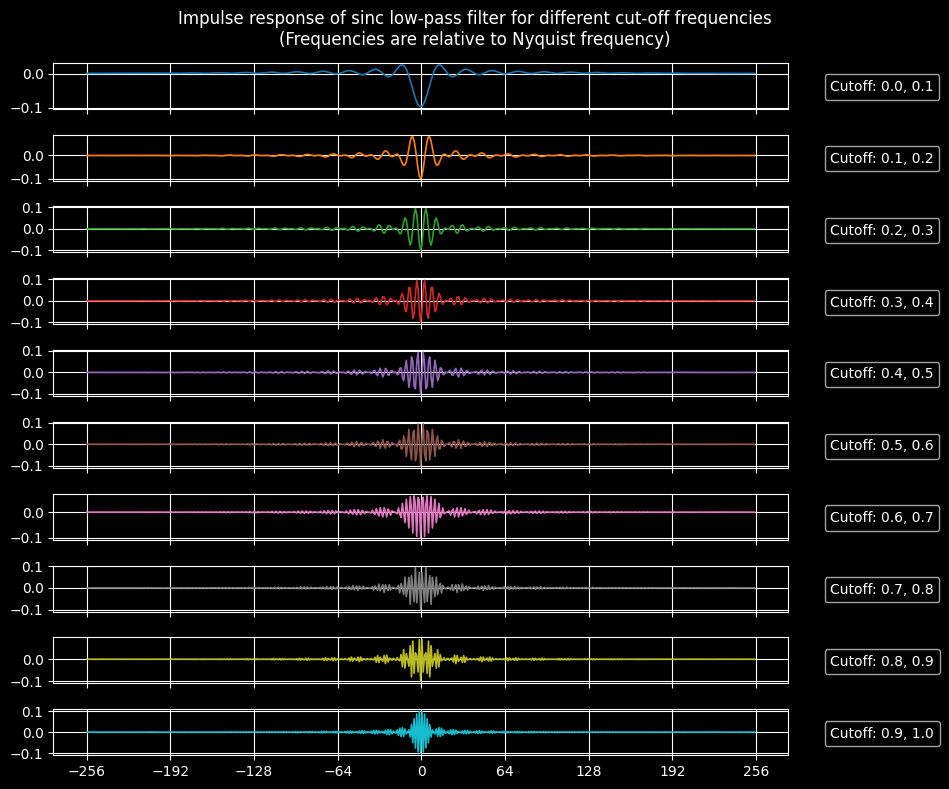

In [ ]:
coff = [f"{l.item():.1f}, {h.item():.1f}" for l, h in zip(c_low, c_high)]
plot_sinc_ir(irs, coff)

#### Frequency Response




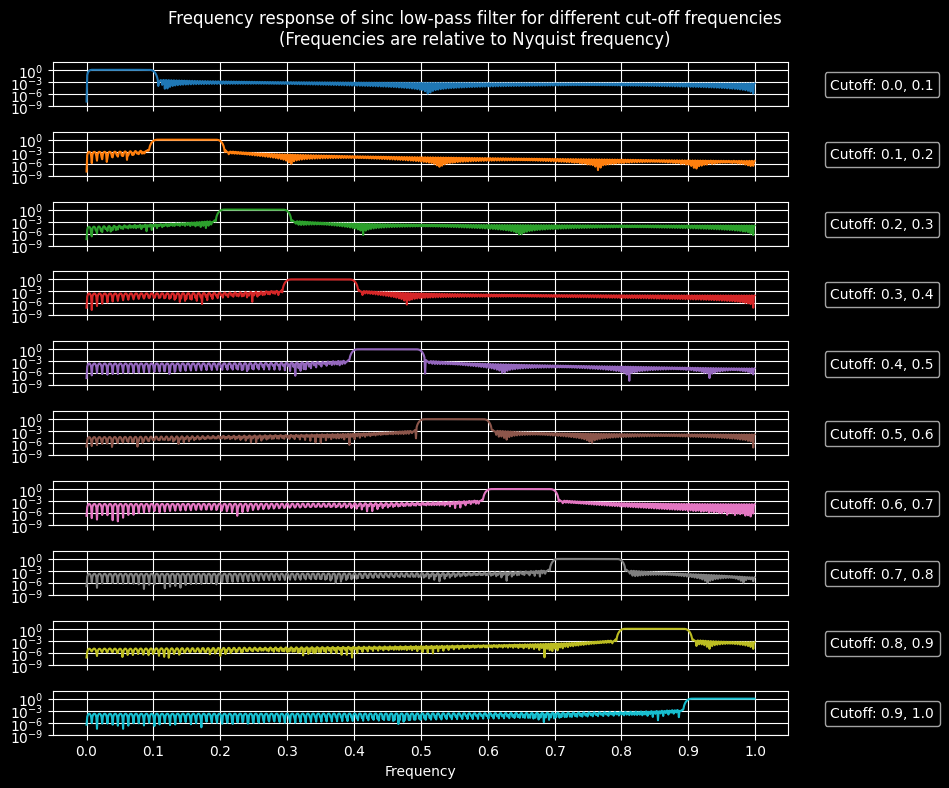

In [ ]:
plot_sinc_fr(frs, coff, band=True)

## Frequency Sampling

The next method we look into starts from a desired frequency response
and obtain impulse response by applying inverse Fourier transform.

:py:func:`~torchaudio.prototype.functional.frequency_impulse_response`
takes (unnormalized) magnitude distribution of frequencies and
construct impulse response from it.

Note however that the resulting impulse response does not produce the
desired frequency response.

In the following, we create multiple filters and compare the input
frequency response and the actual frequency response.




### Brick-wall filter

Let's start from brick-wall filter



In [ ]:
magnitudes = torch.concat([torch.ones((128,)), torch.zeros((128,))])
ir = frequency_impulse_response(magnitudes)

print("Magnitudes:", magnitudes.shape)
print("Impulse Response:", ir.shape)

Magnitudes: torch.Size([256])
Impulse Response: torch.Size([510])


In [ ]:
def plot_ir(magnitudes, ir, num_fft=2048):
    fr = torch.fft.rfft(ir, n=num_fft, dim=0).abs()
    ir_size = ir.size(-1)
    half = ir_size // 2

    fig, axes = plt.subplots(3, 1)
    t = torch.linspace(-half, half - 1, ir_size)
    axes[0].plot(t, ir)
    axes[0].grid(True)
    axes[0].set(title="Impulse Response")
    axes[0].set_xticks([i * half // 4 for i in range(-4, 5)])
    t = torch.linspace(0, 1, fr.numel())
    axes[1].plot(t, fr, label="Actual")
    axes[2].semilogy(t, fr, label="Actual")
    t = torch.linspace(0, 1, magnitudes.numel())
    for i in range(1, 3):
        axes[i].plot(t, magnitudes, label="Desired (input)", linewidth=1.1, linestyle="--")
        axes[i].grid(True)
    axes[1].set(title="Frequency Response")
    axes[2].set(title="Frequency Response (log-scale)", xlabel="Frequency")
    axes[2].legend(loc="center right")
    fig.tight_layout()

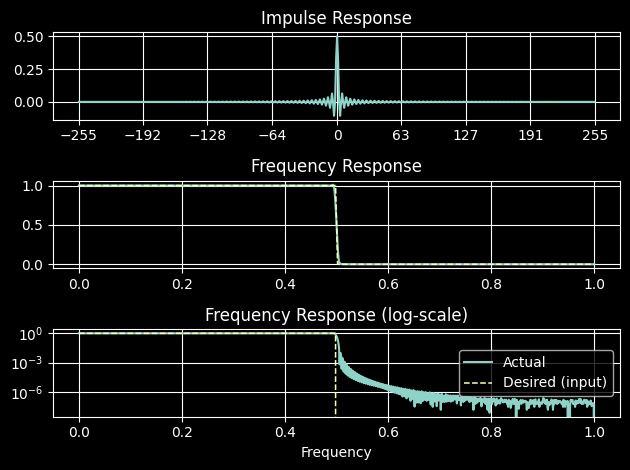

In [ ]:
plot_ir(magnitudes, ir)

Notice that there are artifacts around the transition band. This is
more noticeable when the window size is small.




In [ ]:
magnitudes = torch.concat([torch.ones((32,)), torch.zeros((32,))])
ir = frequency_impulse_response(magnitudes)

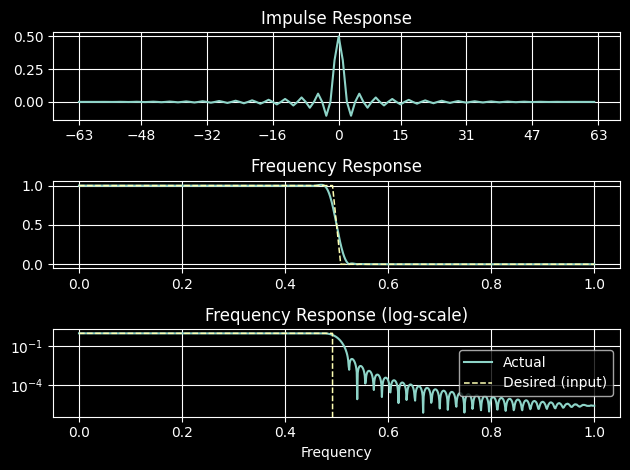

In [ ]:
plot_ir(magnitudes, ir)

### Arbitrary shapes





In [ ]:
magnitudes = torch.linspace(0, 1, 64) ** 4.0
ir = frequency_impulse_response(magnitudes)

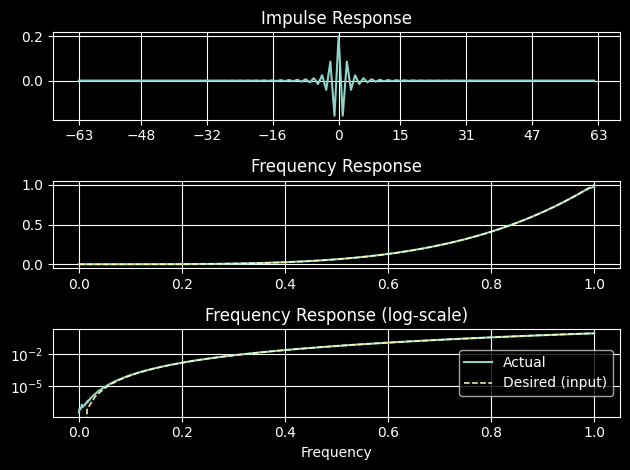

In [ ]:
plot_ir(magnitudes, ir)

In [ ]:
magnitudes = torch.sin(torch.linspace(0, 10, 64)) ** 4.0
ir = frequency_impulse_response(magnitudes)

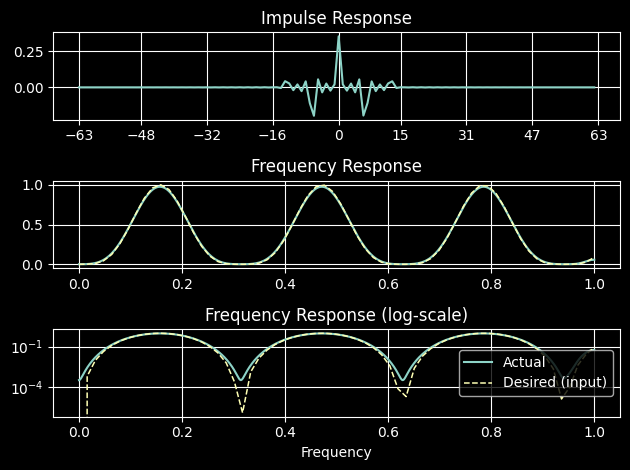

In [ ]:
plot_ir(magnitudes, ir)

## References

- https://en.wikipedia.org/wiki/Sinc_filter
- https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch16.pdf
- https://courses.engr.illinois.edu/ece401/fa2020/slides/lec10.pdf
- https://ccrma.stanford.edu/~jos/sasp/Windowing_Desired_Impulse_Response.html


